C:\Users\Dell\AppData\Local\Temp\ipykernel_26724\1178722867.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


successful try:  1
successful try:  2
successful try:  3
successful try:  4
successful try:  5
successful try:  6
successful try:  7
successful try:  8
successful try:  9
successful try:  10
successful try:  11
successful try:  12
successful try:  13
successful try:  14


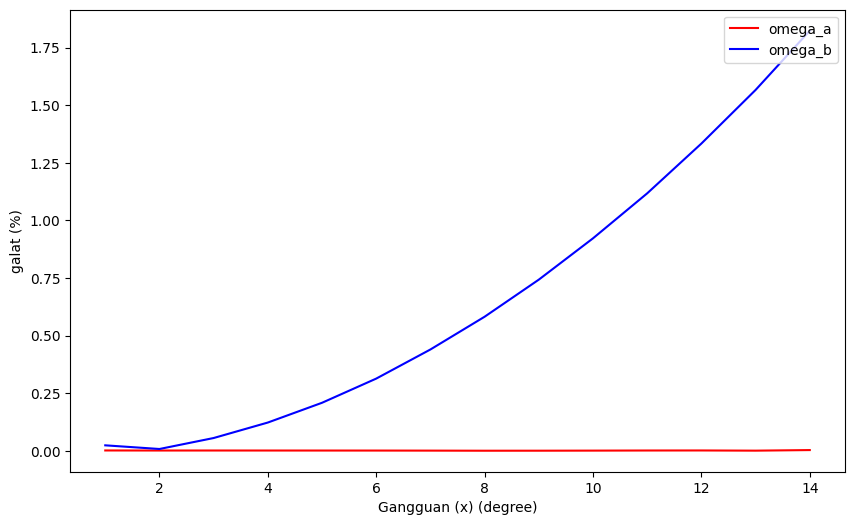

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

# Constants
g = 9.81  # gravitational acceleration (m/s^2)
L1 = 1.0  # length of the first pendulum (m)
L2 = 0.5  # length of the second pendulum (m)
m1 = 5.0  # mass of the first pendulum (kg)
m2 = 1.0  # mass of the second pendulum (kg)

x_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
omega_a = [i for i in x_list]
omega_b = [i for i in x_list]
w_a_fit1 = [i for i in x_list]
w_a_fit2 = [i for i in x_list]
w_b_fit1 = [i for i in x_list]
w_b_fit2 = [i for i in x_list]
iter = 0
for x in x_list:
    # Initial conditions
    theta1_0 = x/2 * np.pi / 180      # initial angle of the first pendulum (rad)
    theta2_0 = -x * np.pi / 180    # initial angle of the second pendulum (rad)
    z1_0 = x * np.pi / 180       # initial angular velocity of the first pendulum (rad/s)
    z2_0 = 0.0                      # initial angular velocity of the second pendulum (rad/s)

    # inisiasi eigenvalue - eigenvector
    max_error = 1E-12     # batas error
    a = np.array([[L1 / g,  (m2 * L2)/((m1 + m2) * g)], 
                [L1 / g,  L2 / g]])

    # pencarian eigenvalue metode QR
    i=0
    while abs(a[1,0]) > max_error:
        q, r = np.linalg.qr(a)
        a = np.dot(r, q)
        i += 1

    omega_a[iter] = 1/np.sqrt(a[0,0])
    omega_b[iter] = 1 / np.sqrt(a[1,1])

    # pencarian eigenvector
    k_a = L1 / (g * a[0,0] - L2)
    k_b = L1 / (g * a[1,1] - L2)

    # analytic solution function
    A_1a = (k_b * theta1_0 - theta2_0) / (k_b - k_a)
    A_1b = (k_a * theta1_0 - theta2_0) / (k_a - k_b)
    alpha_b = (k_a * z1_0 - z2_0) / ((k_a - k_b) * A_1b * omega_b[iter])
    alpha_a = (k_b * z1_0 - z2_0) / ((k_b - k_a) * A_1a * omega_a[iter])
    def analytic_theta1(t):
        c_a = np.cos(omega_a[iter] * t)
        s_a = np.sin(omega_a[iter] * t)
        c_b = np.cos(omega_b[iter] * t)
        s_b = np.sin(omega_b[iter] * t)
        return A_1a * (c_a + alpha_a * s_a) + A_1b * (c_b + alpha_b * s_b)

    def analytic_theta2(t):
        c_a = np.cos(omega_a[iter] * t)
        s_a = np.sin(omega_a[iter] * t)
        c_b = np.cos(omega_b[iter] * t)
        s_b = np.sin(omega_b[iter] * t)
        return A_1a * k_a * (c_a + alpha_a * s_a) + A_1b * k_b * (c_b + alpha_b * s_b)

    # Equations of motion
    def equations(t, y):
        theta1, z1, theta2, z2 = y

        delta_theta = theta1 - theta2

        denom1 = L1 * (2 * m1 + m2 - m2 * np.cos(2 * delta_theta))
        denom2 = L2 * (2 * m1 + m2 - m2 * np.cos(2 * delta_theta))

        theta1_dot = z1
        theta2_dot = z2

        z1_dot = (
            -g * (2 * m1 + m2) * np.sin(theta1)
            - m2 * g * np.sin(theta1 - 2 * theta2)
            - 2 * np.sin(delta_theta) * m2 * (L2 * z2**2 + L1 * z1**2 * np.cos(delta_theta))
        ) / denom1

        z2_dot = (
            2 * np.sin(delta_theta)
            * (
                L1 * (m1 + m2) * z1**2
                + g * (m1 + m2) * np.cos(theta1)
                + L2 * m2 * z2**2 * np.cos(delta_theta)
            )
        ) / denom2

        return [theta1_dot, z1_dot, theta2_dot, z2_dot]

    # Time span and resolution
    t_span = (0, 10)  # time range (s)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)  # time points for evaluation

    # Solve the system of ODEs
    initial_conditions = [theta1_0, z1_0, theta2_0, z2_0]
    solution = solve_ivp(equations, t_span, initial_conditions, t_eval=t_eval, method="RK45")

    # Extract solutions
    t = solution.t
    y1 = solution.y[0]  # theta1
    y2 = solution.y[2]  # theta2

    analytic_y_1 = analytic_theta1(t)
    analytic_y_2 = analytic_theta2(t)

    # regresi nonlinear
    from scipy.optimize import curve_fit
    # Fungsi model
    def trig_function(t, A, w_a, a, B, w_b, b):
        return A * (np.cos(w_a * t) + a * np.sin(w_a * t)) + B * (np.cos(w_b * t) + b * np.sin(w_b * t))

    # Data sintetis
    x_data = np.linspace(0, 10, 100)
    A_true, w_a_true, a_true = 2.0, 1.0, 0.5
    B_true, w_b_true, b_true = 1.5, 0.8, 0.2
    y_data = trig_function(x_data, A_true, w_a_true, a_true, B_true, w_b_true, b_true)
    y_data_noisy = y_data + np.random.normal(0, 0.2, len(y_data))  # Tambahkan noise

    # Regresi nonlinier
    initial_guess1 = [A_1a, omega_a[iter], alpha_a, A_1b, omega_b[iter], alpha_b]  # Tebakan awal untuk A, w_a, a, B, w_b, b
    params1, covariance = curve_fit(trig_function, t, y1, p0=initial_guess1)
    initial_guess2 = [A_1a * k_a, omega_a[iter], alpha_a, A_1b * k_b, omega_b[iter], alpha_b]  # Tebakan awal untuk A, w_a, a, B, w_b, b
    params2, covariance = curve_fit(trig_function, t, y2, p0=initial_guess1)

    # Hasil parameter
    A_fit1, w_a_fit1[iter], a_fit1, B_fit1, w_b_fit1[iter], b_fit1 = params1

    # print("Hasil parameter:")
    # print(f"A = {A_fit1}, w_a = {w_a_fit1}, a = {a_fit1}")
    # print(f"B = {B_fit1}, w_b = {w_b_fit1}, b = {b_fit1}")

    A_fit2, w_a_fit2[iter], a_fit2, B_fit2, w_b_fit2 [iter], b_fit2 = params1
    # print("Hasil parameter:")
    # print(f"A = {A_fit2}, w_a = {w_a_fit2}, a = {a_fit2}")
    # print(f"B = {B_fit2}, w_b = {w_b_fit2}, b = {b_fit2}")
    iter +=1
    print("successful try: ", iter)

# Plot hasil
plt.figure(figsize=(10, 6))
# plt.scatter(t, y1, label='y1', s=10)
plt.plot(x_list, [abs(fit - actual) / actual * 100 for fit, actual in zip(w_a_fit1, omega_a)], label='omega_a', color='red')
plt.plot(x_list, [abs(fit - actual) / actual * 100 for fit, actual in zip(w_b_fit1, omega_b)], label='omega_b', color='blue')
# plt.plot(t, y1 * 180 / np.pi, label='theta1', color='green', linestyle='dashed')
plt.legend(loc="upper right")
plt.xlabel('Gangguan (x) (degree)')
plt.ylabel('galat (%)')
# plt.title('Regresi Nonlinier pada Fungsi Trigonometri')
plt.show()
